In [1]:
%matplotlib inline
import composeml as cp
import pandas as pd

In [2]:
PARTITION = '100'
BASE_DIR = 's3://customer-churn-spark/'
PARTITION_DIR = BASE_DIR + 'p' + PARTITION
transactions = f'{PARTITION_DIR}/transactions.csv'

In [3]:
transactions = pd.read_csv(
    transactions,
    parse_dates=['transaction_date', 'membership_expire_date'],
    infer_datetime_format=True,
)

transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,39,30,149,149,1,2015-09-30,2015-11-13,0
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,34,30,149,149,1,2016-02-29,2016-03-31,0
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,29,30,180,180,1,2017-01-31,2017-03-01,0
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,41,30,99,99,1,2017-01-31,2017-02-28,0
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,40,30,149,149,1,2016-05-04,2016-06-08,0


In [4]:
month_begin = pd.offsets.MonthBegin()
expire_date = transactions['membership_expire_date']
transactions['lead_time'] = expire_date.apply(month_begin.rollback)
transactions[['msno', 'lead_time', 'membership_expire_date']].head()

,msno,lead_time,membership_expire_date
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,2015-11-01,2015-11-13
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,2016-03-01,2016-03-31
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,2017-03-01,2017-03-01
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,2017-02-01,2017-02-28
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,2016-06-01,2016-06-08


In [5]:
def inactive_membership(transactions, now):
    membership_expire_date = transactions['membership_expire_date'].iloc[0]
    next_transaction_exists = len(transactions) > 1

    if next_transaction_exists:
        next_transaction_date = transactions['transaction_date'].iloc[1]
        elapsed = next_transaction_date - membership_expire_date

    else:
        elapsed = now - membership_expire_date

    return elapsed

In [6]:
label_maker = cp.LabelMaker(
    target_entity='msno',
    time_index='lead_time',
    labeling_function=inactive_membership,
    window_size=2,
)

In [7]:
now = pd.Timestamp.now()

label_times = label_maker.search(
    transactions,
    minimum_data=0,
    num_examples_per_instance=2,
    gap=1,
    verbose=True,
    now=now,
)

label_times.head()

Elapsed: 00:27 | Remaining: 00:00 | Progress: 100%|██████████| msno: 4978/4978 


,msno,cutoff_time,inactive_membership
label_id,,,
0,+/6nRSzfF+CIynhnBM5xz8J6ArlSdLY74gsNK09dbes=,2015-06-01,1507 days 15:35:38.825435
1,+1TKL6EWVDuKFAOvWZOsoGTILy2POMnxxvUgP7PPCy8=,2016-11-01,982 days 15:35:38.825435
2,+58aOzMPOZSi0END5IUKzK009k/iGY9mB+k9s5qetAI=,2016-11-01,988 days 15:35:38.825435
3,+6UN6VJD8u9vZm4lZRAREpzBRM4YoeOSWhEX0c5JBAU=,2016-09-01,93 days 00:00:00
4,+6UN6VJD8u9vZm4lZRAREpzBRM4YoeOSWhEX0c5JBAU=,2017-01-01,4 days 00:00:00


In [8]:
one_month = pd.Timedelta('31d')
is_churn = label_times.threshold(one_month)
is_churn.head()

,msno,cutoff_time,inactive_membership
label_id,,,
0,+/6nRSzfF+CIynhnBM5xz8J6ArlSdLY74gsNK09dbes=,2015-06-01,True
1,+1TKL6EWVDuKFAOvWZOsoGTILy2POMnxxvUgP7PPCy8=,2016-11-01,True
2,+58aOzMPOZSi0END5IUKzK009k/iGY9mB+k9s5qetAI=,2016-11-01,True
3,+6UN6VJD8u9vZm4lZRAREpzBRM4YoeOSWhEX0c5JBAU=,2016-09-01,True
4,+6UN6VJD8u9vZm4lZRAREpzBRM4YoeOSWhEX0c5JBAU=,2017-01-01,False


Label Distribution
------------------
False     3017
True      1062
Total:    4079


Settings
--------
num_examples_per_instance    2
minimum_data                 0
window_size                  2
gap                          1


Transforms
----------
1. threshold
  - value:    31 days 00:00:00



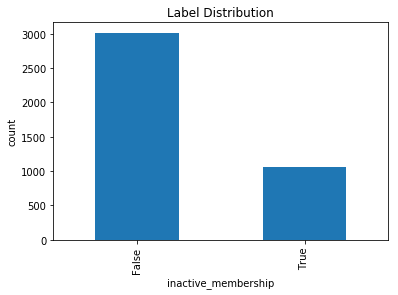

In [9]:
is_churn.describe()
is_churn.plot.distribution()